# Part 2: Tranfer learning pipeline
Julianne Freeman<br>
Insight Data Science Fellow 2018B

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext version_information
%version_information numpy, scipy, matplotlib, pandas

Software versions
Python 3.6.3 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 5.1.0
OS Darwin 16.1.0 x86_64 i386 64bit
numpy 1.14.4
scipy 0.18.1
matplotlib 2.0.0
pandas 0.19.2
Sat Jul 07 22:07:38 2018 PDT

In [3]:
from datetime import datetime 
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
from collections import Counter

#never print matching warnings
warnings.filterwarnings('ignore') 

#set to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#import seaborn to draw pretty graphs
import seaborn as sns
sns.set_style('whitegrid')

#to load images
from PIL import Image

#keras model
from keras import applications, optimizers, utils
from keras import backend as k 
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, Convolution2D, MaxPooling2D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

#tensorflow
import tensorflow as tf

#random
import random

#import images
import sys
import argparse
import cv2

#classification report
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

from sklearn.cross_validation import train_test_split

# Train model
Opted to use the bottleneck method in order to make fine tuning of the model easier. Using the bottleneck method, I only had to run the data through the top two layers of the NCC during fine tuning.

In [4]:
### GENERAL SET UP ###

path     ='/Users/juliannefreeman/Documents/Insight/Project/imgs/final2/model'
trainpath='/Users/juliannefreeman/Documents/Insight/Project/imgs/final2/model/train'
validpath='/Users/juliannefreeman/Documents/Insight/Project/imgs/final2/model/validation'

batch_size = 16
image_height = 224 #224 is needed for VGG16
image_width = 224
classes = 4

In [ ]:
# Data augumentation would decrease risk of overfitting
# This would be used if the bottleneck method was not being used.
# On a CPU, unfortunately, fine tuning is too computationally intensive to initiate in a timely matter
# without using the bottleneck method

'''train_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

test_datagen = ImageDataGenerator(
rescale = 1./255,
horizontal_flip = True,
fill_mode = "nearest",
zoom_range = 0.3,
width_shift_range = 0.3,
height_shift_range=0.3,
rotation_range=30)

train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size = (img_height, img_width),
batch_size = batch_size, 
class_mode = "categorical")

validation_generator = test_datagen.flow_from_directory(
validation_data_dir,
target_size = (img_height, img_width),
class_mode = "categorical")'''

In [5]:
### SET UP DATA  ###

# train data
count=0
folders = os.listdir(trainpath)
for folder in folders:
    if folder != '.DS_Store':
        currfolder=trainpath+'/'+folder
        imgs = os.listdir(currfolder)
        for img in imgs:
            if img != '.DS_Store':
                count+=1
                curr_img = image.load_img(currfolder+'/'+img, target_size=(image_height, image_width))
                x = image.img_to_array(curr_img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                if count==1:
                    data=x
                else:
                    data=np.append(data,x, axis=0)
                    
traindata=data
print('traindata shape')
traindata.shape

# training labels

train_labels = np.array([0] * 800 + [1] * 800 + [2] * 800 + [3] * 800)
train_labels=utils.to_categorical(train_labels, num_classes=classes)
print('trainlabels shape')
train_labels.shape

print('loaded training data and made labels')

traindata shape


(3200, 224, 224, 3)

trainlabels shape


(3200, 4)

loaded training data and made labels


In [6]:
# validation data

count=0
folders = os.listdir(validpath)
for folder in folders:
    if folder != '.DS_Store':
        currfolder=validpath+'/'+folder
        imgs = os.listdir(currfolder)
        for img in imgs:
            if img != '.DS_Store':
                count+=1
                curr_img = image.load_img(currfolder+'/'+img, target_size=(224, 224))
                x = image.img_to_array(curr_img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                if count==1:
                    data=x
                else:
                    data=np.append(data,x, axis=0)
                    
validdata=data
print('validdata shape')
validdata.shape

# validation label

validation_labels = np.array([0] * 200 + [1] * 200 + [2] * 200 + [3] * 200)
validation_labels=utils.to_categorical(validation_labels, num_classes=4)
print('validlabels shape')
validation_labels.shape

print('loaded validation data and made labels')

validdata shape


(800, 224, 224, 3)

validlabels shape


(800, 4)

loaded validation data and made labels


In [77]:
# build the model

basemodel = applications.VGG16(weights='imagenet', include_top=False)
print('built basemodel\n')

# run data through model

train_data = basemodel.predict(traindata)
train_data.shape
validation_data = basemodel.predict(validdata)
validation_data.shape

print('ran training and validation data through basemodel')

# save data

os.chdir(path)
np.save(open('VGG16_bottleneck_train_data_final.npy', 'wb'), train_data)
np.save(open('VGG16_bottleneck_valid_data_final.npy', 'wb'), validation_data)

print ('saved data')

# load model

os.chdir(path)
train_data = np.load(open('VGG16_bottleneck_train_data_final.npy', 'rb'))
train_data.shape
validation_data = np.load(open('VGG16_bottleneck_valid_data_final.npy', 'rb'))
validation_data.shape

print('loaded data')

built basemodel



(3200, 7, 7, 512)

(800, 7, 7, 512)

ran training and validation data through basemodel
saved data


(3200, 7, 7, 512)

(800, 7, 7, 512)

loaded data


# Fine tuning
While only displaing the final result, I tested the following parameters during fine tuning.
- Number of dense layers
- Number of neurons in dense layers
- Optimizer
- Learning rate of optimizer
- Dropout

In [82]:
# create top model

model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled model')

# fit data to model 
history_finalmodel = model.fit(train_data, train_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data, validation_labels))
print('fit model')

# save weights

os.chdir(path)
model.save_weights('VGG16_top_model_weights_final.h5')
print('saved weights')

compiled model
Train on 3200 samples, validate on 800 samples
Epoch 1/15
3200/3200 [==============================] - 11s 3ms/step - loss: 7.9823 - acc: 0.4978 - val_loss: 5.7460 - val_acc: 0.6412

# Checking for overfitting
It is important to check loss of the validation set to ensure the model is not overfitting to the training data. I restricted the number of epochs to below the point at which the validation loss begins to rise (a clear sign of overfitting).

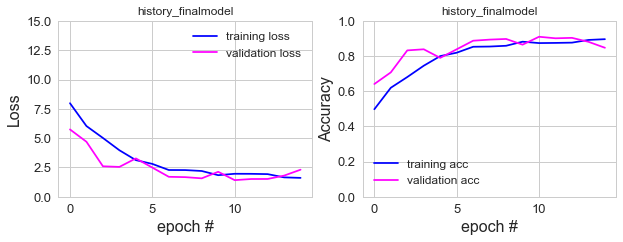

In [181]:
axis_size=16
legend_size=12
title_size=18

fig, axes = plt.subplots(1,2,figsize=(10,11))

_=plt.subplot(3, 2, 1)
_=plt.plot(history_finalmodel.history['loss'],label='training loss', color='blue')
_=plt.plot(history_finalmodel.history['val_loss'],label='validation loss', color='magenta')
_=plt.ylim(0,15)
_=plt.legend(prop={'size': legend_size})
_=plt.tick_params(axis='both', which='major', labelsize=13)
_=plt.xlabel('epoch #', fontsize=axis_size)
_=plt.ylabel('Loss', fontsize=axis_size)
_=plt.title('history_finalmodel')

_=plt.subplot(3, 2, 2)
_=plt.plot(history_finalmodel.history['acc'],label='training acc', color='blue')
_=plt.plot(history_finalmodel.history['val_acc'],label='validation acc', color='magenta')
_=plt.legend(prop={'size': legend_size})
_=plt.ylim(0,1)
_=plt.xlabel('epoch #', fontsize=axis_size)
_=plt.ylabel('Accuracy', fontsize=axis_size)
_=plt.tick_params(axis='both', which='major', labelsize=13)
_=plt.title('history_finalmodel')

# Load test images for cross-validation

In [155]:
testdir='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model_accuracy/final_flip_sample_openpose_all2'
count=0
os.chdir(testdir)
imgs = os.listdir(testdir)
for img in sorted(imgs):
    if img != '.DS_Store':
        count+=1
        curr_img = image.load_img(img, target_size=(224, 224))
        x = image.img_to_array(curr_img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        if count==1:
            test_data=x
        else:
            test_data=np.append(data,x,axis=0)
test_data.shape

(801, 224, 224, 3)

# Create test labels

In [156]:
test_labels = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)
test_labels=utils.to_categorical(test_labels, num_classes=4)
print('test_labels shape')
test_labels.shape

test_labels shape


(400, 4)

# Build pre-trained VGG16

In [157]:
# build the model
basemodel = applications.VGG16(weights='imagenet', include_top=False)
print('built basemodel\n')

built basemodel



In [160]:
# run data through bottleneck model
bottleneck_test_data = basemodel.predict(validdata)
bottleneck_test_data.shape[1:]

(7, 7, 512)

In [92]:
# build top model
model = Sequential()
model.add(Flatten(input_shape=bottleneck_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled model')

compiled model


In [93]:
# load weights
os.chdir(path)
model.load_weights('VGG16_top_model_weights_final.h5')
print('loaded weights into top model')

loaded weights into top model


In [94]:
# run data through top model
print('top model prediction')
predictions=model.predict(bottleneck_data)

top model prediction


# Check results

In [95]:
pred_classes=np.argmax(predictions, axis=1)
pred_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2,
       2, 0, 2, 0, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 0, 2, 0,
       0, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 3,

In [99]:
true_classes = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,

In [175]:
# find number of incorrectly items
right=pred_classes
wrong0=[x for x in pred_classes[:100] if x != 0]
wrong1=[x for x in pred_classes[100:200] if x != 1]
wrong2=[x for x in pred_classes[200:300] if x != 2]
wrong3=[x for x in pred_classes[300:400] if x != 3]

#length of array
len_wrong=len(wrong0)+len(wrong1)+len(wrong2)+len(wrong3)
len_right=len(right)

#calc accuracy
accuracy=((len_right-len_wrong)/len_right)*100
accuracy

80.5

# Classification report

In [100]:
predictions = predictions
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.array([0] * 100 + [1] * 100 + [2] * 100 + [3] * 100)
class_labels = ['other','reversewarrior','trianglepose','warrior2']

In [101]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                precision    recall  f1-score   support

         other       0.58      0.89      0.70       100
reversewarrior       0.91      0.93      0.92       100
  trianglepose       1.00      0.43      0.60       100
      warrior2       0.96      0.97      0.97       100

   avg / total       0.86      0.81      0.80       400



# Confusion matrix

In [103]:
a=pred_classes
a=['other' if x==0 else x for x in a]
a=['reversewarrior' if x==1 else x for x in a]
a=['trianglepose' if x==2 else x for x in a]
a=['warrior2' if x==3 else x for x in a]
pred_classes_words=a

In [104]:
a=true_classes
a=['other' if x==0 else x for x in a]
a=['reversewarrior' if x==1 else x for x in a]
a=['trianglepose' if x==2 else x for x in a]
a=['warrior2' if x==3 else x for x in a]
true_classes_words=a

In [106]:
def cm_analysis(y_true, y_pred, labels, filename='none.pdf', ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap != None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)

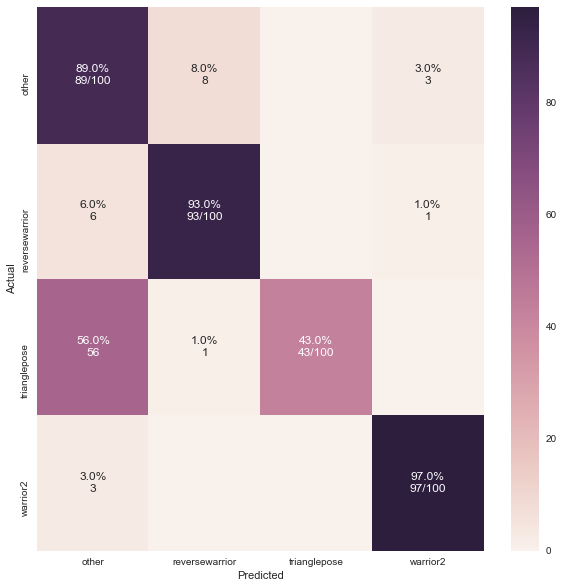

In [107]:
os.chdir(maindir)
curr_labels=['other','reversewarrior','trianglepose','warrior2']
cm_analysis(true_classes_words, pred_classes_words, labels=curr_labels)

# Test if processing with OpenPose improved results

First, prep data. Will not have to do everything since data was already partially processed for the "real" model.

Next, flip images

In [108]:
def imgs_flip(file, size, ipath, opath):
    os.chdir(ipath)
    im = Image.open(file)
    newim=im.transpose(Image.FLIP_LEFT_RIGHT)
    os.chdir(opath)
    newfile=os.path.splitext(file)[0]+'_flipped.jpg'
    
    #same new and old image
    im.save(file,"JPEG")
    newim.save(newfile,"JPEG")

In [110]:
ipath ='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/imgs_random'
opath ='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/imgs_random_flipped'

folders=os.listdir(ipath)
for folder in folders:
    
    if folder != '.DS_Store':
        
        print(folder)
        
        origpath=ipath+'/'+folder
        savepath=opath+'/'+folder
        
        #find all imgs
        files = os.listdir(origpath)

        for file in files:
            if file.split(".")[-1] == "jpg":

                #load image
                os.chdir(origpath)
                im = Image.open(file)

                #create new image
                newfile=os.path.splitext(file)[0]+'_flipped.jpg'
                newim=im.transpose(Image.FLIP_LEFT_RIGHT)

                #save new and old image
                os.chdir(savepath)     
                im.save(file,"JPEG")
                newim.save(newfile,"JPEG")

other
reversewarrior
trianglepose
warrior2


### finally, split data into train (80) and train (20)

In [114]:
#define paths
ipath     ='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/imgs_random_flipped'
train_path='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model_wo_openpose/train'
valid_path='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model_wo_openpose/validation'


folders=os.listdir(ipath)
for folder in folders:
    if folder!='.DS_Store':
        print(folder)
        count=0
        origpath=ipath+'/'+folder
        train_savepath=train_path+'/'+folder
        valid_savepath=valid_path+'/'+folder
        
        #find all imgs
        files = os.listdir(origpath)
        if files[0]=='.DS_Store':
            files=files[1:]
        random.shuffle(files)
        
        x_train ,x_test = train_test_split(files,test_size=0.2)
        len(files)
        len(x_train)
        len(x_test)
        
        for file in x_train:
            os.chdir(origpath)
            im=Image.open(file)
            os.chdir(train_savepath)
            im.save(file,"JPEG")
            
        for file in x_test:
            os.chdir(origpath)
            im=Image.open(file)
            os.chdir(valid_savepath)
            im.save(file,"JPEG")


other


1000

800

200

reversewarrior


1000

800

200

trianglepose


1000

800

200

warrior2


1000

800

200

### build model

In [115]:
### GENERAL SET UP ###

path     ='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model'
trainpath='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model/train'
validpath='/Users/juliannefreeman/Documents/Insight/Project/imgs/final/model/validation'

batch_size = 16
image_height = 224
image_width = 224
classes = 4

In [117]:
### SET UP DATA  ###

# train data
count=0
folders = os.listdir(trainpath)
for folder in folders:
    if folder != '.DS_Store':
        currfolder=trainpath+'/'+folder
        imgs = os.listdir(currfolder)
        for img in imgs:
            if img != '.DS_Store':
                count+=1
                curr_img = image.load_img(currfolder+'/'+img, target_size=(224, 224))
                x = image.img_to_array(curr_img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                if count==1:
                    data=x
                else:
                    data=np.append(data,x, axis=0)
                    
traindata_wo=data
print('traindata shape')
traindata_wo.shape

# training labels

traindata_wo_labels = np.array([0] * 800 + [1] * 800 + [2] * 800 + [3] * 800)
traindata_wo_labels=utils.to_categorical(traindata_wo_labels, num_classes=4)
print('trainlabels shape')
traindata_wo_labels.shape

print('loaded training data and made labels')

traindata shape


(3200, 224, 224, 3)

trainlabels shape


(3200, 4)

loaded training data and made labels


In [118]:
# validation data

count=0
folders = os.listdir(validpath)
for folder in folders:
    if folder != '.DS_Store':
        currfolder=validpath+'/'+folder
        imgs = os.listdir(currfolder)
        for img in imgs:
            if img != '.DS_Store':
                count+=1
                curr_img = image.load_img(currfolder+'/'+img, target_size=(224, 224))
                x = image.img_to_array(curr_img)
                x = np.expand_dims(x, axis=0)
                x = preprocess_input(x)
                if count==1:
                    data=x
                else:
                    data=np.append(data,x, axis=0)
                    
validdata_wo=data
print('validdata shape')
validdata_wo.shape

# validation label

validdata_wo_labels = np.array([0] * 200 + [1] * 200 + [2] * 200 + [3] * 200)
validdata_wo_labels=utils.to_categorical(validdata_wo_labels, num_classes=4)
print('validlabels shape')
validdata_wo_labels.shape

print('loaded validation data and made labels')

validdata shape


(800, 224, 224, 3)

validlabels shape


(800, 4)

loaded validation data and made labels


In [120]:
# build the model

basemodel = applications.VGG16(weights='imagenet', include_top=False)
print('built basemodel\n')

built basemodel



In [121]:
# run data through model

train_data_wo = basemodel.predict(traindata_wo)
train_data_wo.shape
validation_data_wo = basemodel.predict(validdata_wo)
validation_data_wo.shape

print('ran training and validation data through basemodel')

# save data

os.chdir(path)
np.save(open('VGG16_bottleneck_train_data_final_wo.npy', 'wb'), train_data_wo)
np.save(open('VGG16_bottleneck_valid_data_final_wo.npy', 'wb'), validation_data_wo)

print ('saved data')

# load model

os.chdir(path)
train_data_wo = np.load(open('VGG16_bottleneck_train_data_final_wo.npy', 'rb'))
train_data_wo.shape
validation_data_wo = np.load(open('VGG16_bottleneck_valid_data_final_wo.npy', 'rb'))
validation_data_wo.shape

print('loaded data')

(3200, 7, 7, 512)

(800, 7, 7, 512)

ran training and validation data through basemodel
saved data


(3200, 7, 7, 512)

(800, 7, 7, 512)

loaded data


# Fine tuning
Did preliminary steps of fine tuning to ensure that differences so that the accuracy of this model was maximized in order to have the best comparison to the accuracy of the previous model.

In [128]:
# create top model

model = Sequential()
model.add(Flatten(input_shape=train_data_wo.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print('compiled model')

# fit data to model 
history_finalmodel_wo3 = model.fit(train_data_wo, traindata_wo_labels,
          epochs=15,
          batch_size=batch_size,
          validation_data=(validation_data_wo, validdata_wo_labels))
print('fit model')

# save weights

os.chdir(path)
model.save_weights('VGG16_top_model_weights_final_wo3.h5')
print('saved weights')

compiled model
Train on 3200 samples, validate on 800 samples
Epoch 1/15
3200/3200 [==============================] - 11s 3ms/step - loss: 9.5432 - acc: 0.4037 - val_loss: 7.9475 - val_acc: 0.4950

# Check for overfitting, again

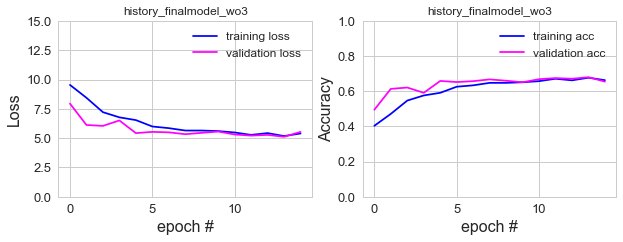

In [130]:
axis_size=16
legend_size=12
title_size=18

fig, axes = plt.subplots(1,2,figsize=(10,11))

_=plt.subplot(3, 2, 1)
_=plt.plot(history_finalmodel_wo3.history['loss'],label='training loss', color='blue')
_=plt.plot(history_finalmodel_wo3.history['val_loss'],label='validation loss', color='magenta')
_=plt.ylim(0,15)
_=plt.legend(prop={'size': legend_size})
_=plt.tick_params(axis='both', which='major', labelsize=13)
_=plt.xlabel('epoch #', fontsize=axis_size)
_=plt.ylabel('Loss', fontsize=axis_size)
_=plt.title('history_finalmodel_wo3')

_=plt.subplot(3, 2, 2)
_=plt.plot(history_finalmodel_wo3.history['acc'],label='training acc', color='blue')
_=plt.plot(history_finalmodel_wo3.history['val_acc'],label='validation acc', color='magenta')
_=plt.legend(prop={'size': legend_size})
_=plt.ylim(0,1)
_=plt.xlabel('epoch #', fontsize=axis_size)
_=plt.ylabel('Accuracy', fontsize=axis_size)
_=plt.tick_params(axis='both', which='major', labelsize=13)
_=plt.title('history_finalmodel_wo3')